# Machine Translation with Transformer

In this notebook, you will understand how to use Transformers introduced in [Vaswani et al., 2017]  You will learn how to load a pretrained Transformer model and evaluate it on `newstest2014`. In addition, you are able to translate a few sentences youself with the `BeamSearchTranslator`.

## Preparation

We start with some usual preparation such as importing libraries and setting the environment.


In [1]:
import random
import math

import numpy as np
import mxnet as mx
from mxnet import gluon, nd
from mxnet.gluon import nn
import gluonnlp as nlp

np.random.seed(100)
random.seed(100)
mx.random.seed(10000)
ctx = mx.gpu(0)

from utils import setup_source, source
setup_source()

# Transformer Architecture

The Transformer model is also based on the encoder-decoder architecture. It,
however, differs to the seq2seq model that the transformer replaces the
recurrent layers in seq2seq with attention layers. To deal with sequential
inputs, each item in the sequential is copied as the query, the key and the
value as illustrated in :numref:`fig_self_attention`. It therefore outputs a same length
sequential output. We call such an attention layer as a self-attention layer.

![Self-attention architecture.](../img/self-attention.svg)

:label:`fig_self_attention`



<!-- Compared to a recurrent layer, output items of a self-attention layer can be computed in parallel and, therefore, it is easy to obtain a high-efficient implementation. -->

The transformer architecture, with a comparison to the seq2seq model with
attention, is shown in :numref:`fig_transformer`. These two models are similar to
each other in overall: the source sequence embeddings are fed into $n$ repeated
blocks. The outputs of the last block are then used as attention memory for the
decoder.  The target sequence embeddings is similarly fed into $n$ repeated
blocks in the decoder, and the final outputs are obtained by applying a dense
layer with vocabulary size to the last block's outputs.

![The transformer architecture.](../img/transformer.svg)

:label:`fig_transformer`


It can also be seen that the transformer differs to the seq2seq with attention model in three major places:

1. A recurrent layer in seq2seq is replaced with a transformer block. This block contains a self-attention layer (multi-head attention) and a network with two dense layers (position-wise FFN) for the encoder. For the decoder, another multi-head attention layer is used to take the encoder state.
1. The encoder state is passed to every transformer block in the decoder, instead of using as an additional input of the first recurrent layer in seq2seq.
1. Since the self-attention layer does not distinguish the item order in a sequence, a positional encoding layer is used to add sequential information into each sequence item.

In the rest of this section, we will explain every new layer introduced by the transformer, and construct a model to train on the machine translation dataset.

# Attention Mechanism

In :numref:`chapter_seq2seq`, we encode the source sequence input information in the recurrent unit state and then pass it to the decoder to generate the target sequence. A token in the target sequence may closely relate to some tokens in the source sequence instead of the whole source sequence. For example, when translating "Hello world." to "Bonjour le monde.", "Bonjour" maps to "Hello" and "monde" maps to "world". In the seq2seq model, the decoder may implicitly select the corresponding information from the state passed by the decoder. The attention mechanism, however, makes this selection explicit.

Attention is a generalized pooling method with bias alignment over inputs. The core component in the attention mechanism is the attention layer, or called attention for simplicity. An input of the attention layer is called a query. For a query, the attention layer returns the output based on its memory, which is a set of key-value pairs. To be more specific, assume a query $\mathbf{q}\in\mathbb R^{d_q}$, and the memory contains $n$ key-value pairs, $(\mathbf{k}_1, \mathbf{v}_1), \ldots, (\mathbf{k}_n, \mathbf{v}_n)$, with $\mathbf{k}_i\in\mathbb R^{d_k}$, $\mathbf{v}_i\in\mathbb R^{d_v}$. The attention layer then returns an output $\mathbf o\in\mathbb R^{d_v}$ with the same shape as a value.

![The attention layer returns an output based on the input query and its memory.](../img/attention.svg)

To compute the output, we first assume there is a score function $\alpha$ which measures the similarity between the query and a key. Then we compute all $n$ scores $a_1, \ldots, a_n$ by

$$a_i = \alpha(\mathbf q, \mathbf k_i).$$

Next we use softmax to obtain the attention weights

$$b_1, \ldots, b_n = \textrm{softmax}(a_1, \ldots, a_n).$$

The output is then a weighted sum of the values

$$\mathbf o = \sum_{i=1}^n b_i \mathbf v_i.$$

Different choices of the score function lead to different attention layers. We will discuss two commonly used attention layers in the rest of this section. Before diving into the implementation, we first introduce a masked version of the softmax operator and explain a specialized dot operator `nd.batched_dot`.

## Masked Softmax

The masked softmax enables enforcing causality when computing attention weights.
It takes the attention scores and a mask as input and filters out masked scores when computing the attention weights.

In [2]:
source(nlp.model.attention_cell._masked_softmax)

Construct two examples, where each example is a 2-by-4 matrix.

In [3]:
data = nd.random.uniform(shape=(2,2,4))
mask = nd.ones(shape=(2,2,4))
mask[0, :, 2:] = 0
mask[1, :, 3:] = 0
nlp.model.attention_cell._masked_softmax(nd, data, mask, data.dtype)


[[[0.49104288 0.50895715 0.         0.        ]
  [0.4118593  0.58814067 0.         0.        ]]

 [[0.29469743 0.42473418 0.28056836 0.        ]
  [0.2910362  0.47771612 0.23124772 0.        ]]]
<NDArray 2x2x4 @cpu(0)>

The operator `nd.batched_dot` takes two inputs $X$ and $Y$ with shapes $(b, n, m)$ and $(b, m, k)$, respectively. It computes $b$ dot products, with `Z[i,:,:]=dot(X[i,:,:], Y[i,:,:]` for $i=1,\ldots,n$.

In [4]:
nd.batch_dot(nd.ones((2,1,3)), nd.ones((2,3,2)))


[[[3. 3.]]

 [[3. 3.]]]
<NDArray 2x1x2 @cpu(0)>

## Dot Product Attention

The dot product assumes the query has the same dimension as the keys, namely $\mathbf q, \mathbf k_i \in\mathbb R^d$ for all $i$. It computes the score by an inner product between the query and a key, often then divided by $\sqrt{d}$ to make the scores less sensitive to the dimension $d$. In other words,

$$\alpha(\mathbf q, \mathbf k) = \langle \mathbf q, \mathbf k \rangle /\sqrt{d}.$$

Assume $\mathbf Q\in\mathbb R^{m\times d}$ contains $m$ queries and $\mathbf K\in\mathbb R^{n\times d}$ has all $n$ keys. We can compute all $mn$ scores by

$$\alpha(\mathbf Q, \mathbf K) = \mathbf Q \mathbf K^T /\sqrt{d}.$$

Now let's implement this layer that supports a batch of queries and key-value pairs. In addition, it supports randomly dropping some attention weights as a regularization.

In [5]:
class DotProductAttention(nn.Block): 
    def __init__(self, dropout, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)

    # query: (batch_size, #queries, d)
    # key: (batch_size, #kv_pairs, d)
    # value: (batch_size, #kv_pairs, dim_v)
    # mask: (batch_size, #queries, #kv_pairs)
    def forward(self, query, key, value, mask=None):
        d = query.shape[-1]
        # set transpose_b=True to swap the last two dimensions of key
        scores = nd.batch_dot(query, key, transpose_b=True) / math.sqrt(d)
        attention_weights = nlp.model.attention_cell._masked_softmax(mx.nd, scores, mask, scores.dtype)
        attention_weights = self.dropout(attention_weights)
        return nd.batch_dot(attention_weights, value)

In gluonnlp available as `nlp.model.DotProductAttentionCell`.

Now we create two batches, and each batch has one query and 10 key-value pairs. 
We specify through `mask` that for the first batch, we will only pay attention to the first key-value pair, while for the second batch, we will check the first 6 key-value pairs. Therefore, though both batches have the same query and key-value pairs, we obtain different outputs.

In [6]:
atten = DotProductAttention(dropout=0.5)
atten.initialize()
X = nd.broadcast_axis(nd.arange(5).reshape((1,5,1)), axis=0, size=2)
mask = nd.ones(shape=(2,5,5))
mask[0, :, 2:] = 0
mask[1, :, 4:] = 0
atten(X, X, X, mask)


[[[0.5       ]
  [0.7310586 ]
  [0.880797  ]
  [0.95257413]
  [0.98201376]]

 [[1.5       ]
  [2.492653  ]
  [2.8448246 ]
  [2.9476287 ]
  [2.9813433 ]]]
<NDArray 2x5x1 @cpu(0)>

## Multi-Head Attention

![Multi-head attention](../img/multi-head-attention.svg)

A multi-head attention layer consists of $h$ parallel attention layers, each one is called a head. For each head, we use three dense layers with hidden sizes $p_q$, $p_k$ and $p_v$ to project the queries, keys and values, respectively, before feeding into the attention layer. The outputs of these $h$ heads are concatenated and then projected by another dense layer.

To be more specific, assume we have the learnable parameters
$\mathbf W_q^{(i)}\in\mathbb R^{p_q\times d_q}$,
$\mathbf W_k^{(i)}\in\mathbb R^{p_k\times d_k}$,
and $\mathbf W_v^{(i)}\in\mathbb R^{p_v\times d_v}$,
 for $i=1,\ldots,h$, and $\mathbf W_o\in\mathbb R^{d_o\times h p_v}$. Then the output for each head can be obtained by

$$\mathbf o^{(i)} = \textrm{attention}(\mathbf W_q^{(i)}\mathbf q, \mathbf W_k^{(i)}\mathbf k,\mathbf W_v^{(i)}\mathbf v),$$

where $\text{attention}$ can be any attention layer introduced before. Since we already have learnable parameters, the simple dot product attention is used.

Then we concatenate all outputs and project them to obtain the multi-head attention output

$$\mathbf o = \mathbf W_o \begin{bmatrix}\mathbf o^{(1)}\\\vdots\\\mathbf o^{(h)}\end{bmatrix}.$$

In practice, we often use $p_q=p_k=p_v=d_o/h$. The hyper-parameters for a multi-head attention, therefore, contain the number heads $h$, and output feature size $d_o$.

In [7]:
class MultiHeadAttention(nn.Block):
    def __init__(self, units, num_heads, dropout, **kwargs):  # units = d_o
        super(MultiHeadAttention, self).__init__(**kwargs)
        assert units % num_heads == 0
        self.num_heads = num_heads
        self.attention = DotProductAttention(dropout)
        self.W_q = nn.Dense(units, use_bias=False, flatten=False)
        self.W_k = nn.Dense(units, use_bias=False, flatten=False)
        self.W_v = nn.Dense(units, use_bias=False, flatten=False)

    # query, key, and value shape: (batch_size, num_items, dim)
    # mask shape is (batch_size, query_length, memory_length)
    def forward(self, query, key, value, mask):
        # Project and transpose from (batch_size, num_items, units) to
        # (batch_size * num_heads, num_items, p), where units = p * num_heads.
        query, key, value = [transpose_qkv(X, self.num_heads) for X in (
            self.W_q(query), self.W_k(key), self.W_v(value))]
        if mask is not None:
            # Replicate mask for each of the num_heads heads
            mask = nd.broadcast_axis(nd.expand_dims(mask, axis=1),
                                    axis=1, size=self.num_heads)\
                    .reshape(shape=(-1, 0, 0), reverse=True)
        output = self.attention(query, key, value, mask)
        # Transpose from (batch_size * num_heads, num_items, p) back to
        # (batch_size, num_items, units)
        return transpose_output(output, self.num_heads)

Here are the definitions of the transpose functions.

In [8]:
def transpose_qkv(X, num_heads):
    # Shape after reshape: (batch_size, num_items, num_heads, p)
    # 0 means copying the shape element, -1 means inferring its value
    X = X.reshape((0, 0, num_heads, -1))
    # Swap the num_items and the num_heads dimensions
    X = X.transpose((0, 2, 1, 3))
    # Merge the first two dimensions. Use reverse=True to infer
    # shape from right to left
    return X.reshape((-1, 0, 0), reverse=True)

def transpose_output(X, num_heads):
    # A reversed version of transpose_qkv
    X = X.reshape((-1, num_heads, 0, 0), reverse=True)
    X = X.transpose((0, 2, 1, 3))
    return X.reshape((0, 0, -1))

Create a multi-head attention with the output size $d_o$ equals to 100, the output will share the same batch size and sequence length as the input, but the last dimension will be equal to $d_o$.

In [9]:
cell = MultiHeadAttention(units=100, num_heads=10, dropout=0.5)
cell.initialize()
cell(X, X, X, mask).shape

(2, 5, 100)

In gluonnlp available as `nlp.model.MultiHeadAttentionCell`.

## Position-wise Feed-Forward Networks

The position-wise feed-forward network accepts a 3-dim input with shape (batch size, sequence length, feature size). It consists of two dense layers that applies to the last dimension, which means the same dense layers are used for each position item in the sequence, so called position-wise.

In [10]:
class PositionWiseFFN(nn.Block):
    def __init__(self, units, hidden_size, **kwargs):
        super(PositionWiseFFN, self).__init__(**kwargs)
        self.ffn_1 = nn.Dense(hidden_size, flatten=False, activation='relu')
        self.ffn_2 = nn.Dense(units, flatten=False)

    def forward(self, X):
        return self.ffn_2(self.ffn_1(X))

Similar to the multi-head attention, the position-wise feed-forward network will only change the last dimension size of the input. In addition, if two items in the input sequence are identical, the according outputs will be identical as well.

In [11]:
ffn = PositionWiseFFN(4, 8)
ffn.initialize()
ffn(nd.ones((2, 3, 4)))[0]


[[ 0.00481268 -0.00251495  0.00616072  0.00038246]
 [ 0.00481268 -0.00251495  0.00616072  0.00038246]
 [ 0.00481268 -0.00251495  0.00616072  0.00038246]]
<NDArray 3x4 @cpu(0)>

## Add and Norm

The input and the output of a multi-head attention layer or a position-wise feed-forward network are combined by a block that contains a residual structure and a layer normalization layer.

Layer normalization is similar batch normalization, but the mean and variances are calculated along the last dimension, e.g `X.mean(axis=-1)` instead of the first batch dimension, e.g. `X.mean(axis=0)`.

In [12]:
layer = nn.LayerNorm()
layer.initialize()
batch = nn.BatchNorm()
batch.initialize()
X = nd.array([[1,2],[2,3]])
# compute mean and variance from X in the training mode.
with mx.autograd.record():
    print('layer norm:',layer(X), '\nbatch norm:', batch(X))

layer norm: 
[[-0.99998  0.99998]
 [-0.99998  0.99998]]
<NDArray 2x2 @cpu(0)> 
batch norm: 
[[-0.99998 -0.99998]
 [ 0.99998  0.99998]]
<NDArray 2x2 @cpu(0)>


The connection block accepts two inputs $X$ and $Y$, the input and output of an other block. Within this connection block, we apply dropout on $Y$.

In [13]:
class AddNorm(nn.Block):
    def __init__(self, dropout, **kwargs):
        super(AddNorm, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
        self.norm = nn.LayerNorm()

    def forward(self, X, Y):
        return self.norm(self.dropout(Y) + X)

Due to the residual connection, $X$ and $Y$ should have the same shape.

In [14]:
add_norm = AddNorm(0.5)
add_norm.initialize()
add_norm(nd.ones((2,3,4)), nd.ones((2,3,4))).shape

(2, 3, 4)

## Positional Encoding

Unlike the recurrent layer, both the multi-head attention layer and the position-wise feed-forward network compute the output of each item in the sequence independently. This property allows us to parallel the computation but is inefficient to model the sequence information. The transformer model therefore adds positional information into the input sequence.

Assume $X\in\mathbb R^{l\times d}$ is the embedding of an example, where $l$ is the sequence length and $d$ is the embedding size. This layer will create a positional encoding $P\in\mathbb R^{l\times d}$ and output $P+X$, with $P$ defined as following:

$$P_{i,2j} = \sin(i/10000^{2j/d}),\quad P_{i,2j+1} = \cos(i/10000^{2j/d}),$$

for $i=0,\ldots,l-1$ and $j=0,\ldots,\lfloor(d-1)/2\rfloor$.

In [15]:
def position_encoding_init(max_length, dim):
    X = nd.arange(0, max_length).reshape((-1,1)) / nd.power(
            10000, nd.arange(0, dim, 2)/dim)
    position_weight = nd.zeros((max_length, dim))

    position_weight[:, 0::2] = nd.sin(X)
    position_weight[:, 1::2] = nd.cos(X)
    return position_weight


class PositionalEncoding(nn.Block):
    def __init__(self, units, dropout=0, max_len=1000):
        super(PositionalEncoding, self).__init__()
        self._max_len = max_len
        self._units = units
        self.position_weight = position_encoding_init(max_len, units)
        self.dropout = nn.Dropout(dropout)

    def forward(self, X):
        pos_seq = mx.nd.arange(X.shape[1]).expand_dims(0)
        emb = nd.Embedding(pos_seq, self.position_weight, self._max_len, self._units)
        return self.dropout(X + emb)

Now we visualize the position values for 4 dimensions. As can be seen, the 4th dimension has the same frequency as the 5th but with different offset. The 5th and 6th dimension have a lower frequency.

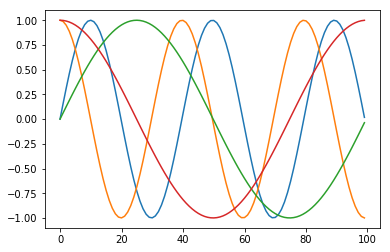

In [16]:
%matplotlib inline

from matplotlib import pyplot as plt

pe = PositionalEncoding(20)
pe.initialize()
X = nd.zeros((1, 100, 20))
Y = pe(X)
_ = plt.plot(np.arange(100), Y.asnumpy()[0, :,4:8])

## Encoder

Now we define the transformer block for the encoder, which contains a multi-head attention layer, a position-wise feed-forward network, and two connection blocks.

In [17]:
class EncoderBlock(nn.Block):
    def __init__(self, units, hidden_size, num_heads, dropout, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)
        self.attention = MultiHeadAttention(units, num_heads, dropout)
        self.add_1 = AddNorm(dropout)
        self.ffn = PositionWiseFFN(units, hidden_size)
        self.add_2 = AddNorm(dropout)

    def forward(self, X, mask):
        Y = self.add_1(X, self.attention(X, X, X, mask))
        return self.add_2(Y, self.ffn(Y))

Due to the residual connections, this block will not change the input shape. It means the `units` argument should be equal to the input's last dimension size.

In [18]:
encoder_blk = EncoderBlock(24, 48, 8, 0.5)
encoder_blk.initialize()
mask = nd.ones(shape=(2, 100, 100))
mask[0, :, 2:] = 0
mask[1, :, 3:] = 0
encoder_blk(nd.ones((2, 100, 24)), mask).shape

(2, 100, 24)

The encoder stacks $n$ blocks. Due to the residual connection again, the embedding layer size $d$ is same as the transformer block output size. Also note that we multiple the embedding output by $\sqrt{d}$ to avoid its values are too small compared to positional encodings.

In [19]:
class TransformerEncoder(nn.Block):
    def __init__(self, vocab_size, units, hidden_size,
                 num_heads, num_layers, dropout, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.units = units
        self.embed = nn.Embedding(vocab_size, units)
        self.pos_encoding = PositionalEncoding(units, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add(
                EncoderBlock(units, hidden_size, num_heads, dropout))

    def forward(self, X, mask, *args):
        X = self.pos_encoding(self.embed(X) * math.sqrt(self.units))
        for blk in self.blks:
            X = blk(X, mask)
        return X

Create an encoder with two transformer blocks, whose hyper-parameters are same as before.

In [20]:
encoder = TransformerEncoder(200, 24, 48, 8, 2, 0.5)
encoder.initialize()
encoder(nd.ones((2, 100)), mask).shape

(2, 100, 24)

## Decoder

![Predict at time step $t$ for a self-attention layer.](../img/self-attention-predict.svg)

Let first look at how a decoder behaviors during predicting. Similar to the seq2seq model, we call $T$ forwards to generate a $T$ length sequence. At time step $t$, assume $\mathbf x_t$ is the current input, i.e. the query. Then keys and values of the self-attention layer consist of the current query with all past queries $\mathbf x_1, \ldots, \mathbf x_{t-1}$.

During training, because the output for the $t$-query could depend all $T$ key-value pairs, which results in an inconsistent behavior than prediction. We can eliminate it by specifying the valid length to be $t$ for the $t$-th query.

Another difference compared to the encoder transformer block is that the decoder block has an additional multi-head attention layer that accepts the encoder outputs as keys and values.

In [21]:
class DecoderBlock(nn.Block):
    # i means it's the i-th block in the decoder
    def __init__(self, units, hidden_size, num_heads, dropout, i, **kwargs):
        super(DecoderBlock, self).__init__(**kwargs)
        self.i = i
        self.attention_1 = MultiHeadAttention(units, num_heads, dropout)
        self.add_1 = AddNorm(dropout)
        self.attention_2 = MultiHeadAttention(units, num_heads, dropout)
        self.add_2 = AddNorm(dropout)
        self.ffn = PositionWiseFFN(units, hidden_size)
        self.add_3 = AddNorm(dropout)

    def forward(self, X, state):
        enc_outputs, enc_valid_lengh = state[0], state[1]
        # state[2][i] contains the past queries for this block
        if state[2][self.i] is None:
            key_values = X
        else:
            key_values = nd.concat(state[2][self.i], X, dim=1)
        state[2][self.i] = key_values
        if mx.autograd.is_training():
            batch_size, seq_len, _ = X.shape
            # shape: (batch_size, seq_len), the values in the j-th column
            # are j+1
            valid_length = nd.arange(
                1, seq_len+1, ctx=X.context).tile((batch_size, 1))
        else:
            valid_length = None

        X2 = self.attention_1(X, key_values, key_values, valid_length)
        Y = self.add_1(X, X2)
        Y2 = self.attention_2(Y, enc_outputs, enc_outputs, enc_valid_lengh)
        Z = self.add_2(Y, Y2)
        return self.add_3(Z, self.ffn(Z)), state

Similar to the encoder block, `units` should be equal to the last dimension size of $X$.

In [22]:
decoder_blk = DecoderBlock(24, 48, 8, 0.5, 0)
decoder_blk.initialize()
X = nd.ones((2, 100, 24))
state = [encoder_blk(X, mask), mask, [None]]
decoder_blk(X, state)[0].shape

(2, 100, 24)

The construction of the decoder is identical to the encoder except for the additional last dense layer to obtain confident scores.

In [23]:
class TransformerDecoder(nn.Block):
    def __init__(self, vocab_size, units, hidden_size,
                 num_heads, num_layers, dropout, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.units = units
        self.num_layers = num_layers
        self.embed = nn.Embedding(vocab_size, units)
        self.pos_encoding = PositionalEncoding(units, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add(
                DecoderBlock(units, hidden_size, num_heads, dropout, i))
        self.dense = nn.Dense(vocab_size, flatten=False)

    def init_state(self, enc_outputs, env_valid_lengh, *args):
        return [enc_outputs, env_valid_lengh, [None]*self.num_layers]

    def forward(self, X, state):
        X = self.pos_encoding(self.embed(X) * math.sqrt(self.units))
        for blk in self.blks:
            X, state = blk(X, state)
        return self.dense(X), state

## Use the Pretrained Transformer model

Next, we load the Transformer model in GluonNLP model zoo, which returns the model + the source and target vocabulary.

In [24]:
import nmt

import warnings
warnings.filterwarnings('ignore')

wmt_transformer_model, wmt_src_vocab, wmt_tgt_vocab = \
    nlp.model.get_model('transformer_en_de_512',
                        dataset_name='WMT2014',
                        pretrained=True,
                        ctx=ctx)
# we are using mixed vocab of EN-DE, so the source and target language vocab are the same
print('#Source Vocab:', len(wmt_src_vocab), ', #Target Vocab:', len(wmt_tgt_vocab))

#Source Vocab: 36794 , #Target Vocab: 36794


In [25]:
print(wmt_transformer_model) # Print the model

NMTModel(
  (encoder): TransformerEncoder(
    (dropout_layer): Dropout(p = 0.1, axes=())
    (layer_norm): LayerNorm(eps=1e-05, axis=-1, center=True, scale=True, in_channels=512)
    (transformer_cells): HybridSequential(
      (0): TransformerEncoderCell(
        (dropout_layer): Dropout(p = 0.1, axes=())
        (attention_cell): MultiHeadAttentionCell(
          (_base_cell): DotProductAttentionCell(
            (_dropout_layer): Dropout(p = 0.1, axes=())
          )
          (proj_query): Dense(512 -> 512, linear)
          (proj_key): Dense(512 -> 512, linear)
          (proj_value): Dense(512 -> 512, linear)
        )
        (proj): Dense(512 -> 512, linear)
        (ffn): PositionwiseFFN(
          (ffn_1): Dense(512 -> 2048, linear)
          (activation): Activation(relu)
          (ffn_2): Dense(2048 -> 512, linear)
          (dropout_layer): Dropout(p = 0.1, axes=())
          (layer_norm): LayerNorm(eps=1e-05, axis=-1, center=True, scale=True, in_channels=512)
        )


The Transformer model architecture is shown as below:

<img src="transformer.png" width="480" align="left"/>

### Load and Preprocess WMT 2014 Dataset

We then load the newstest2014 segment in WMT 2014 English-German test dataset for evaluation purpose.

Firstly, look at the WMT 2014 corpus. `GluonNLP` provides [WMT2014BPE](../../api/modules/data.rst#gluonnlp.data.WMT2014BPE)
and [WMT2014](../../api/modules/data.rst#gluonnlp.data.WMT2014) classes. The former contains a BPE-tokenized dataset, while the later contains the raw text. Here, we use the former for scoring, and the latter for
demonstrating actual translation.

For the BPE, it is one way to convert words to sub-words. E.g, the word **cheapest** will be converted to **cheap@@** and **est**, and **sunnyvale** will be converted to **sunny@@** and **vale**. The representational ability of the vocabulary is greatly improved by using sub-words. This is a common trick in NLP.

In [26]:
import hyperparameters as hparams

wmt_data_test = nlp.data.WMT2014BPE('newstest2014', # BPE: cheapest --> cheap@@, est
                                    src_lang=hparams.src_lang,
                                    tgt_lang=hparams.tgt_lang)
print('Source language %s, Target language %s' % (hparams.src_lang, hparams.tgt_lang))
print('Sample BPE tokens: "{}"'.format(wmt_data_test[14]))

wmt_test_text = nlp.data.WMT2014('newstest2014',
                                 src_lang=hparams.src_lang,
                                 tgt_lang=hparams.tgt_lang)
# For demo process, will only evaluate the prediction of the first 50 sentences
wmt_data_test, wmt_test_text = gluon.data.SimpleDataset([wmt_data_test[i] for i in range(16)]), gluon.data.SimpleDataset([wmt_test_text[i] for i in range(16)])

print('Sample raw text: "{}"'.format(wmt_test_text[14]))

Source language en, Target language de
Sample BPE tokens: "('How the back of the plane is laid out - particularly whether seating is 9 or 10 ab@@ re@@ ast - is central to the economic performance claims being made for new " mini-@@ j@@ umb@@ o " jet designs .', 'Wie der hinter@@ e Teil des Flug@@ zeu@@ gs ausge@@ stal@@ tet ist - insbesondere ob es Reihen mit neun oder zehn Sit@@ zen gibt - , ist entscheidend für die angegebenen wirtschaftlichen Ergebnisse , die das neue " Mini-@@ J@@ umb@@ o " -@@ Design liefern soll .')"
Sample raw text: "('How the back of the plane is laid out - particularly whether seating is 9 or 10 abreast - is central to the economic performance claims being made for new "mini-jumbo" jet designs.', 'Wie der hintere Teil des Flugzeugs ausgestaltet ist – insbesondere ob es Reihen mit neun oder zehn Sitzen gibt –, ist entscheidend für die angegebenen wirtschaftlichen Ergebnisse, die das neue „Mini-Jumbo“-Design liefern soll.')"


In [27]:
# Slice the target part of the dataset using .transform
wmt_test_tgt_sentences = wmt_test_text.transform(lambda src, tgt: tgt)
print('Sample target sentence: "{}"'.format(wmt_test_tgt_sentences[14]))

Sample target sentence: "Wie der hintere Teil des Flugzeugs ausgestaltet ist – insbesondere ob es Reihen mit neun oder zehn Sitzen gibt –, ist entscheidend für die angegebenen wirtschaftlichen Ergebnisse, die das neue „Mini-Jumbo“-Design liefern soll."


We further process the dataset using the `.transform()` API. The preprocessing have the following 4 steps:

1) Clip the source and target sequences

2) Split the string input to a list of tokens

3) Map the string token into its index in the vocabulary

4) Append EOS token to source sentence and add BOS and EOS tokens to target sentence.

In [28]:
import dataprocessor

# wmt_transform_fn includes the four preprocessing steps mentioned above.
wmt_transform_fn = dataprocessor.TrainValDataTransform(wmt_src_vocab, wmt_tgt_vocab)
wmt_dataset_processed = wmt_data_test.transform(wmt_transform_fn, lazy=False)

def get_length_index_fn():
    global idx
    idx = 0
    def transform(src, tgt):
        global idx
        result = (src, tgt, len(src), len(tgt), idx)
        idx += 1
        return result
    return transform

wmt_data_test_with_len = wmt_dataset_processed.transform(get_length_index_fn(), lazy=False)
# Five elements: Source Token Ids, Target Token Ids, Source Seq Length, Target Seq length, Index
print(wmt_data_test_with_len[0][0], '\n', wmt_data_test_with_len[0][1])

[ 7300 21964 23833  1935 24004 11836  6698 11839  5565 25464 27950 22544
 16202 24272     3] 
 [    2  7300 21964 23833  1935 24004 29615  6698 11839  5565 25464 22297
 27121 23712 20558     3]


### Creating `Sampler` and `DataLoader` for the `WMT 2014` Dataset

Now, we have obtained the transformed datasets. The next step is to construct sampler and DataLoader. First, we need to construct batchify function, which pads and stacks sequences to form mini-batch.

In [29]:
wmt_test_batchify_fn = nlp.data.batchify.Tuple(
    nlp.data.batchify.Pad(),                   # Source Token IDs
    nlp.data.batchify.Pad(),                   # Target Token IDs
    nlp.data.batchify.Stack(dtype='float32'),  # Source Sequence Length
    nlp.data.batchify.Stack(dtype='float32'),  # Target Sequence Length
    nlp.data.batchify.Stack())                 # Index

* [Tuple](https://gluon-nlp.mxnet.io/api/modules/data.batchify.html?highlight=batchify#gluonnlp.data.batchify.Tuple) is the GluonNLP way of applying different batchify functions to each element of a dataset item. In this case, we are applying `Pad` to `src` and `tgt`, `Stack` to `len(src)` and `len(tgt)` with conversion to float32, and simple `Stack` to `idx` without type conversion.
* [Pad](https://gluon-nlp.mxnet.io/api/modules/data.batchify.html?highlight=batchify#gluonnlp.data.batchify.Pad) takes the elements from all dataset items in a batch, and pad them according to the item of maximum length to form a padded matrix/tensor.
* [Stack](https://gluon-nlp.mxnet.io/api/modules/data.batchify.html?highlight=batchify#gluonnlp.data.batchify.Stack) simply stacks all elements in a batch, and requires all elements to be of the same length.

We can then construct bucketing samplers, which generate batches by grouping sequences with similar lengths. Here, we use [FixedBucketSampler](https://gluon-nlp.mxnet.io/api/modules/data.html?highlight=fixedbucketsampler#gluonnlp.data.FixedBucketSampler). `FixedBucketSampler` aims to assign each data sample to a bucket based on its length. The buckets are determined automatically.

 Please refer to [BucketSampler](https://gluon-nlp.mxnet.io/api/notes/data_api.html) for more information.

In [30]:
wmt_test_batch_sampler = nlp.data.FixedBucketSampler(
    lengths=wmt_data_test_with_len.transform(lambda src, tgt, src_len, tgt_len, idx: (src_len, tgt_len)), #(src, tgt)
    num_buckets=3,
    batch_size=2)
print(wmt_test_batch_sampler.stats())

FixedBucketSampler:
  sample_num=16, batch_num=9
  key=[(26, 32), (40, 49), (54, 66)]
  cnt=[9, 2, 5]
  batch_size=[2, 2, 2]


Given the samplers, we can use [DataLoader](https://mxnet.apache.org/versions/master/api/python/gluon/data.html#mxnet.gluon.data.DataLoader) to sample the datasets.

In [31]:
wmt_test_data_loader = gluon.data.DataLoader(
    wmt_data_test_with_len,
    batch_sampler=wmt_test_batch_sampler,
    batchify_fn=wmt_test_batchify_fn,
    num_workers=8)  # Note that we can use multi-processing
print('Number of testing batches:', len(wmt_test_data_loader))

Number of testing batches: 9


### Evaluate Transformer

Next, we evaluate the performance of the model on the `newstest2014` dataset. We first define the `BeamSearchTranslator` to generate the translations.

In [32]:
print('Beam Size =', hparams.beam_size, ', Lengh penalty Alpha=', hparams.lp_alpha, ', Length penalty K=', hparams.lp_k)
wmt_translator = nmt.translation.BeamSearchTranslator(
    model=wmt_transformer_model,
    beam_size=hparams.beam_size,
    scorer=nlp.model.BeamSearchScorer(alpha=hparams.lp_alpha, K=hparams.lp_k),
    max_length=200)

Beam Size = 4 , Lengh penalty Alpha= 0.6 , Length penalty K= 5


Then we caculate the `loss` as well as the `bleu` score on the newstest2014 WMT 2014 English-German test dataset. This may take a while.

In [33]:
import time
import utils

eval_start_time = time.time()
wmt_test_loss_function = nlp.loss.MaskedSoftmaxCELoss()
wmt_test_loss_function.hybridize()
wmt_detokenizer = nlp.data.SacreMosesDetokenizer()
wmt_test_loss, wmt_test_translation_out = utils.evaluate(wmt_transformer_model,
                                                         wmt_test_data_loader,
                                                         wmt_test_loss_function,
                                                         wmt_translator,
                                                         wmt_tgt_vocab,
                                                         wmt_detokenizer,
                                                         ctx)
wmt_test_bleu_score, _, _, _, _ = nmt.bleu.compute_bleu([wmt_test_tgt_sentences],
                                                        wmt_test_translation_out,
                                                        tokenized=False,
                                                        tokenizer=hparams.bleu,
                                                        split_compound_word=False,
                                                        bpe=False)
print('WMT14 EN-DE SOTA model test loss: %.2f; test bleu score: %.2f; time cost %.2fs' %(wmt_test_loss, wmt_test_bleu_score * 100, (time.time() - eval_start_time)))

WMT14 EN-DE SOTA model test loss: 1.20; test bleu score: 35.49; time cost 9.79s


In [34]:
print('Sample translations:')
num_pairs = 1

for i in range(num_pairs):
    print('EN:')
    print(wmt_test_text[i][0])
    print('DE-Candidate:')
    print(wmt_test_translation_out[i])
    print('DE-Reference:')
    print(wmt_test_tgt_sentences[i])
    print('========')

Sample translations:
EN:
Orlando Bloom and Miranda Kerr still love each other
DE-Candidate:
Orlando Bloom und Miranda Kerr lieben sich noch immer.
DE-Reference:
Orlando Bloom und Miranda Kerr lieben sich noch immer


### Translation Inference

We herein show the actual translation example (EN-DE) when given a source language using the SOTA Transformer model.

In [35]:
import utils

print('Translate the following English sentence into German:')

sample_src_seq = 'We love language.'
print('[\'' + sample_src_seq + '\']')
sample_tgt_seq = utils.translate(wmt_translator, sample_src_seq, wmt_src_vocab, wmt_tgt_vocab, wmt_detokenizer,
                                 ctx)
print('The German translation is:')
print(sample_tgt_seq)

Translate the following English sentence into German:
['We love language.']
The German translation is:
['Wir sind erfreut darüber, dass']


If you'd like to train your own transformer models, you may find the training scripts in our
[scripts](https://github.com/dmlc/gluon-nlp/tree/master/scripts/machine_translation).

## References

[1] Vaswani, Ashish, et al. "Attention is all you need." Advances in Neural Information Processing Systems. 2017.